In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score



In [83]:
train_data = pd.read_csv('C:/Users/bcspr/OneDrive/Desktop/bigger project/Dataframes/basic_cleaning_done_df.csv')
df = train_data.copy()

In [84]:
df.head()

,Unnamed: 0,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,national_holiday,local_holiday,regional_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,1,1,0


In [140]:
###    place in group by to get oil price per day , 'dcoilwtico': 'mean'

daily_sales = df.groupby('date').agg({'sales': 'sum', 'onpromotion': 'mean','national_holiday': 'mean'}).reset_index().round(3)
daily_sales['date'] = pd.to_datetime(daily_sales['date'])

daily_sales.to_csv('C:/Users/bcspr/OneDrive/Desktop/bigger project/Code/daily_sales.csv')


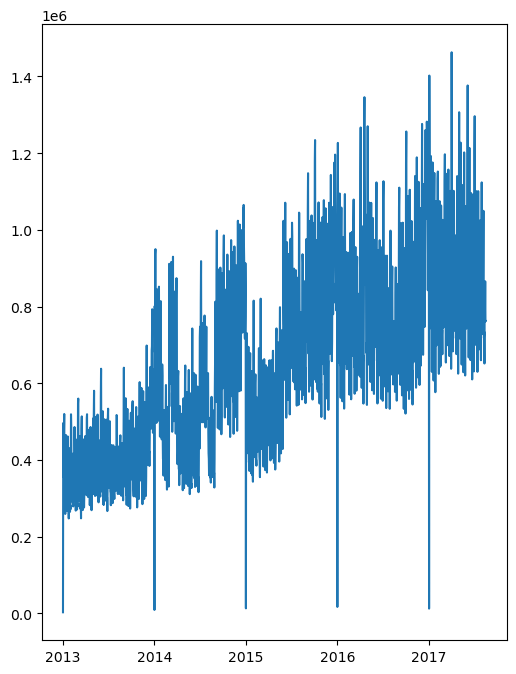

In [86]:
plt.figure(figsize= (6,8))
plt.plot(daily_sales['date'],daily_sales['sales'])
plt.show()

<Axes: ylabel='Frequency'>

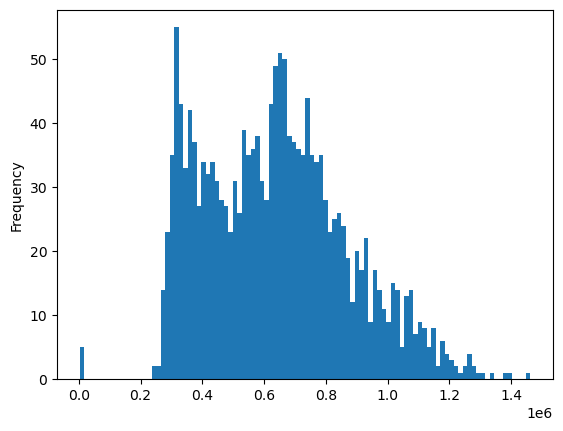

In [129]:
daily_sales['sales'].plot(kind= 'hist', bins = 100)

<Axes: xlabel='date'>

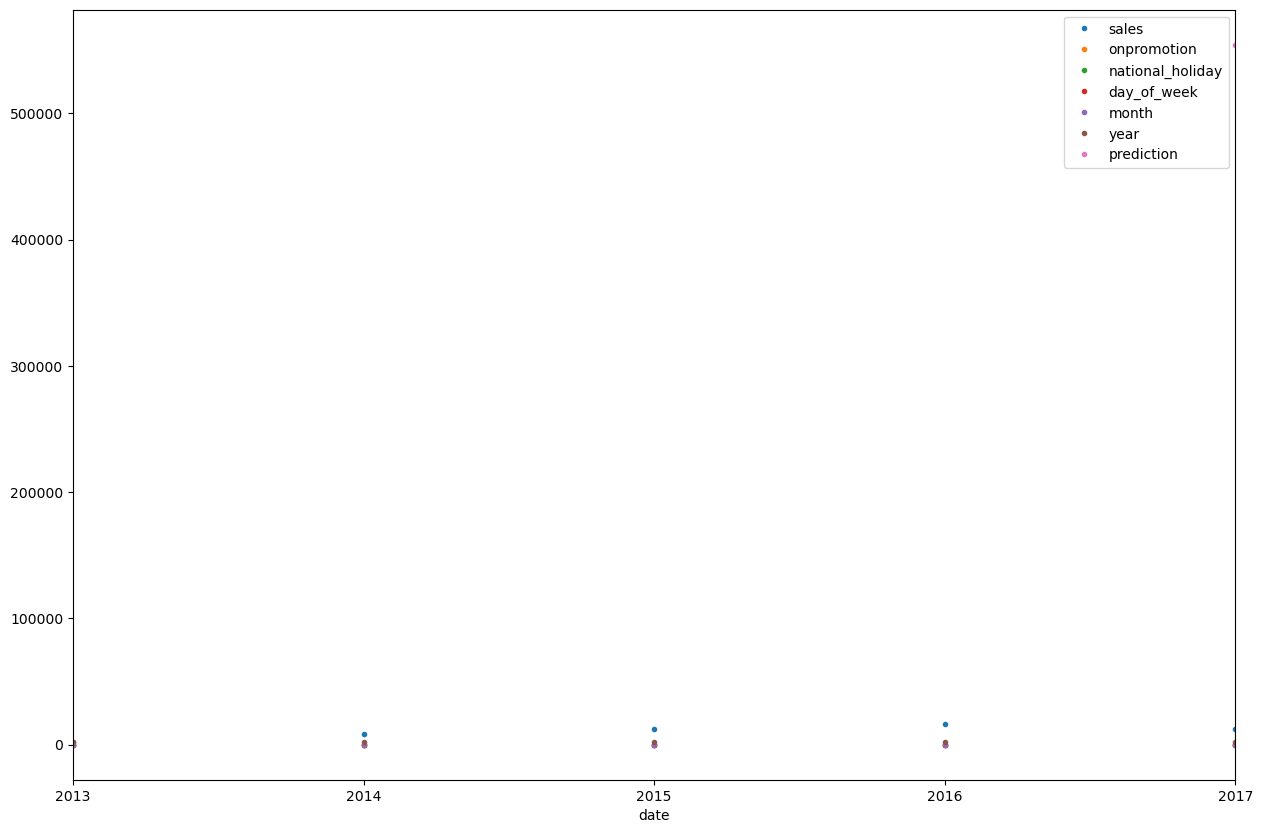

In [135]:
daily_sales.query('sales < 100000').plot (figsize=(15,10),style= '.')

In [137]:
outlier = daily_sales.query('sales < 100000').copy()


#most stores seem to be closed on the first of the year, and a lot of our error comes on dates surrounding it


In [87]:
start_date = '2016-09-01'
end_date = '2016-09-30'
One_month = daily_sales[(daily_sales['date'] >= start_date ) & (daily_sales['date'] <= end_date)].reset_index()

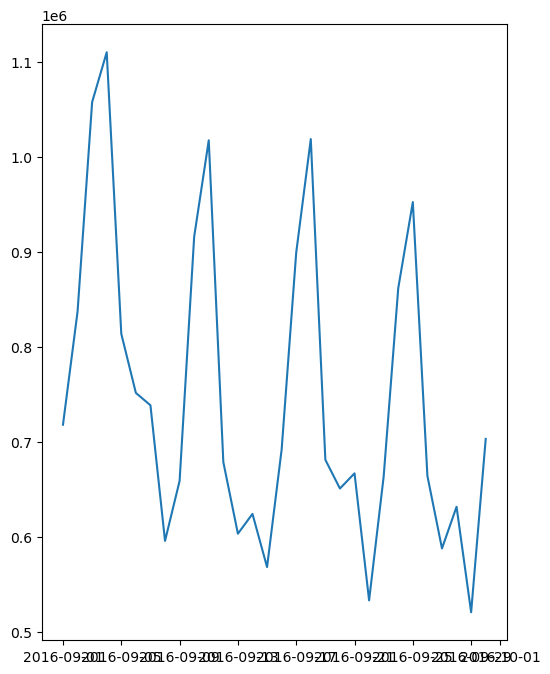

In [88]:
plt.figure(figsize= (6,8))
plt.plot(One_month['date'],One_month['sales'])
plt.show()

In [89]:
#daily_sales['is_open'] = np.where(daily_sales['sales'] == 0, 1, 0)   #### found out the model doesnt use this at all to decide so trying without

daily_sales['day_of_week'] = daily_sales['date'].dt.day_of_week
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales.set_index('date',inplace= True)


In [90]:
train = daily_sales[daily_sales.index < '2016-08-15']
test = daily_sales[daily_sales.index >= '2016-08-15']

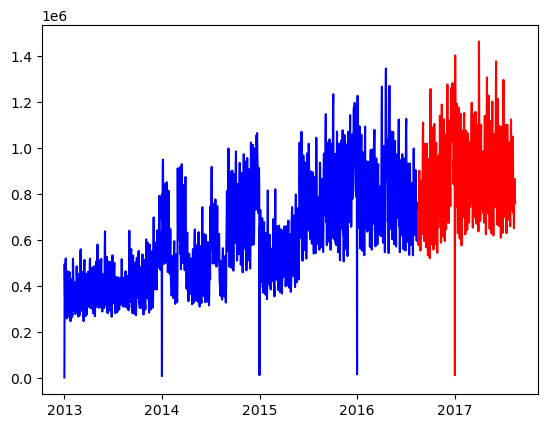

In [91]:
fig, ax = plt.subplots()
ax.plot(train.index,train['sales'],color = 'blue')
ax.plot(test.index,test['sales'],color = 'red')

In [92]:
##split into X and Y

X_train = train.copy()
X_train.drop(columns= 'sales', inplace= True)
y_train = train['sales']



X_test = test.copy()
X_test.drop(columns= 'sales', inplace= True)
y_test = test['sales']

print(X_test.shape)
print(y_test.shape)


(365, 5)
(365,)


In [93]:

reg = xgb.XGBRegressor(n_estimators = 10000, early_stopping_rounds = 50 ,learning_rate = .001)
cv_params = {'colsample_bytree': [0.7],
  'learning_rate': [0.3],
  'max_depth': [4],
  'min_child_weight': [5],
  'n_estimators': [15],
  'subsample': [0.7]
              }

xgb_cv = GridSearchCV(reg, cv_params, scoring='neg_mean_squared_error', cv=5)

xgb_cv.fit(X_train, y_train, 
        eval_set = [(X_train, y_train),(X_test, y_test)], verbose = True 
        )


[0]	validation_0-rmse:443212.81502	validation_1-rmse:634703.85290
[1]	validation_0-rmse:319374.37623	validation_1-rmse:502432.64721
[2]	validation_0-rmse:238069.01047	validation_1-rmse:388467.14409
[3]	validation_0-rmse:179263.23181	validation_1-rmse:307057.68498
[4]	validation_0-rmse:144403.13272	validation_1-rmse:254122.84654
[5]	validation_0-rmse:118804.99930	validation_1-rmse:212092.63972
[6]	validation_0-rmse:105973.75456	validation_1-rmse:188645.52529
[7]	validation_0-rmse:95929.58475	validation_1-rmse:170754.42400
[8]	validation_0-rmse:92637.71305	validation_1-rmse:161635.94855
[9]	validation_0-rmse:88765.50103	validation_1-rmse:156594.20663
[10]	validation_0-rmse:86607.13880	validation_1-rmse:151230.02444
[11]	validation_0-rmse:83407.86259	validation_1-rmse:144356.35130
[12]	validation_0-rmse:81584.38517	validation_1-rmse:140418.30839
[13]	validation_0-rmse:80220.59279	validation_1-rmse:138044.46235
[14]	validation_0-rmse:79411.34746	validation_1-rmse:135780.99237
[0]	validatio

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=50,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.001, ma...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    n_estimators=10000, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.3],
                         'max_depth': [4], 'min_child_weight': [5],
                         'n_estimators': [15], 'subsample': [0.7]},
             scoring='neg_mean_squared_error')

In [94]:
best_params = [xgb_cv.best_params_]
best_params

[{'colsample_bytree': 0.7,
  'learning_rate': 0.3,
  'max_depth': 4,
  'min_child_weight': 5,
  'n_estimators': 15,
  'subsample': 0.7}]

In [95]:
xgb_cv.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=15, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [96]:
reg = xgb.XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, monotone_constraints=None,
              n_estimators=15, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None,)
eval_set = [(X_train, y_train),(X_test, y_test)]
reg.fit(X_train, y_train, 
        eval_set = eval_set, verbose = 10)

[0]	validation_0-rmse:446408.53518	validation_1-rmse:635878.92423
[10]	validation_0-rmse:82217.45453	validation_1-rmse:141447.41805
[14]	validation_0-rmse:75666.59452	validation_1-rmse:127230.34565


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=15, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [97]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index= reg.feature_names_in_,
             columns= ['importance'])
fi

,importance
onpromotion,0.394161
national_holiday,0.039675
day_of_week,0.308074
month,0.066787
year,0.191304


<Axes: title={'center': 'feature importance'}>

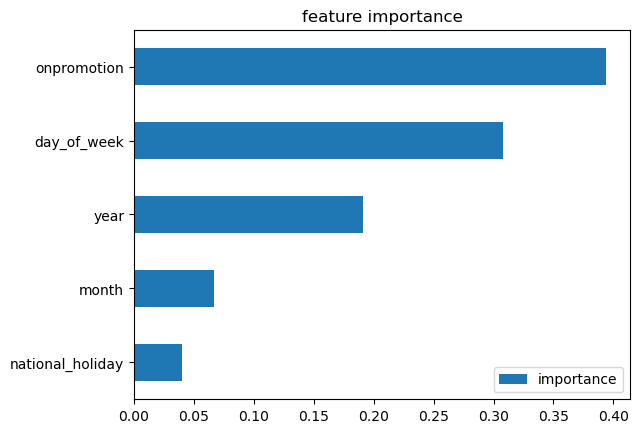

In [98]:
fi.sort_values('importance').plot(kind= 'barh', title = 'feature importance')

In [99]:
test['prediction'] = reg.predict(X_test)
test.head()

C:\Users\bcspr\AppData\Local\Temp\ipykernel_7472\1081397220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


,sales,onpromotion,national_holiday,day_of_week,month,year,prediction
date,,,,,,,
2016-08-15,720032.300,3.886,0.0,0,8,2016,714254.6875
2016-08-16,718671.651,4.992,0.0,1,8,2016,687631.2500
2016-08-17,725945.703,8.106,0.0,2,8,2016,693361.5625
2016-08-18,577350.521,3.842,0.0,3,8,2016,632573.9375
2016-08-19,678767.116,6.830,0.0,4,8,2016,682771.0000


In [100]:
daily_sales = daily_sales.merge(test[['prediction']], how= 'left', left_index= True, right_index= True)
daily_sales

,sales,onpromotion,national_holiday,day_of_week,month,year,prediction
date,,,,,,,
2013-01-01,2511.619,0.000,1.0,1,1,2013,NaN
2013-01-02,496092.418,0.000,0.0,2,1,2013,NaN
2013-01-03,361461.231,0.000,0.0,3,1,2013,NaN
2013-01-04,354459.677,0.000,0.0,4,1,2013,NaN
2013-01-05,477350.121,0.000,1.0,5,1,2013,NaN
...,...,...,...,...,...,...,...
2017-08-11,826373.722,7.957,1.0,4,8,2017,735730.3125
2017-08-12,792630.535,4.664,0.0,5,8,2017,885898.6875
2017-08-13,865639.677,5.209,0.0,6,8,2017,958134.1875


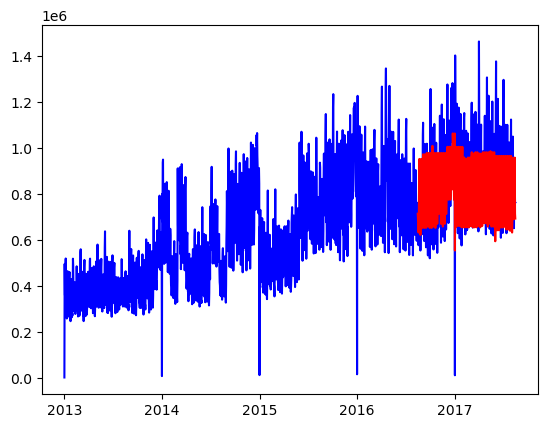

In [102]:
fig, ax = plt.subplots()
ax.plot(daily_sales.index,daily_sales['sales'],color = 'blue')
ax.plot(daily_sales.index,daily_sales['prediction'], color = 'red' )

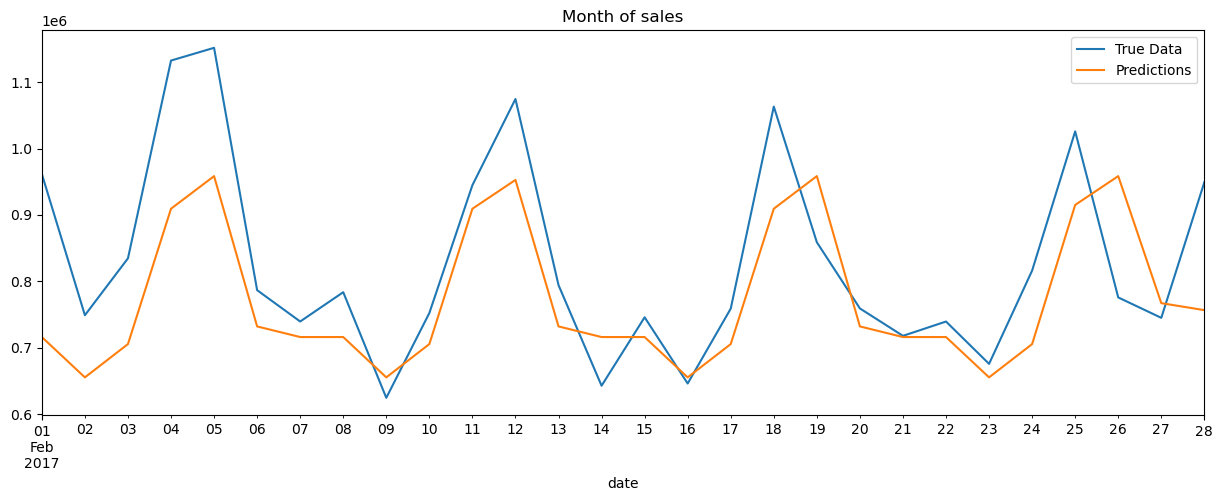

In [117]:
ax = daily_sales.loc[(daily_sales.index >= start_date)& (daily_sales.index <= end_date)]['sales'].plot(figsize=(15,5),title= 'Month of sales')
daily_sales.loc[(daily_sales.index >= start_date)& (daily_sales.index <= end_date)]['prediction'].plot(style= '-')
plt.legend(['True Data','Predictions'])



plt.show()

In [119]:
score = np.sqrt(mean_squared_error(test['sales'],test['prediction']))
score

127230.34493519456

In [121]:
test['error'] = np.abs(test['sales'] - test['prediction'])


In [ ]:
test['date'] = test.index.date

In [127]:
test.groupby('date')['error'].mean().sort_values(ascending = False).head(20)

date
2017-01-02    629485.6210
2017-04-01    545823.9620
2017-01-01    542309.1240
2017-05-01    499546.0545
2017-06-04    410986.5825
2017-01-03    388373.5175
2016-12-30    370077.9755
2017-07-02    330854.2805
2016-12-23    319109.5795
2017-07-01    300619.2345
2017-08-01    295166.2005
2017-03-01    292518.1475
2016-10-02    278116.2960
2017-01-04    274089.9015
2017-08-02    271350.4535
2016-12-04    270931.9110
2017-06-03    269227.4215
2016-10-01    263174.9705
2016-12-20    255396.1380
2016-12-18    255208.7840
Name: error, dtype: float64